# Foundations of Computational Economics #35

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Stochastic consumption-savings model with discretized choice

<img src="_static/img/lecture.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/3FI_05ok66k](https://youtu.be/3FI_05ok66k)

Description: Deaton model of consumption and savings with random returns. Using quadrature to compute the expectation in the Bellman equation.

### Recap: components of the dynamic model

1. **State variables** — vector of variables that describe all relevant
  information about the modeled decision process  
1. **Decision variables** — vector of variables describing the choices, along
  with restrictions on the choice set  
1. **Instantaneous payoff** — utility function, with
  time separable discounted lifetime (overall) utility  
1. **Motion rules** — agent’s beliefs of how state variable evolve
  through time, conditional on choices  


- **Value function** — maximum attainable lifetime utility  
- **Policy function** — mapping from state space to action space that
  results in maximum lifetime utility (the optimal choice)  

### Bellman equation/operator

- Bellman equation has all relevant model parts: fully specifies the model  
- *Equation* when thought of as point-wise equality of two functions  


$$
V(M)=\max_{0 \le c \le M}\big\{u(c)+\beta V(\underset{=M-c}{\underbrace{M'}})\big\}
$$

- *Operator* when thought of as map that takes one (value) function $ V(\cdot) $ as input
  (it goes to the RHS), and returns another (value) function  


$$
T(V)(M)=\max_{0 \le c \le M}\big\{u(c)+\beta V(\underset{=M-c}{\underbrace{M'}})\big\}
$$

*Which problem is this?*

### From cake eating to consumption-savings (in infinite horizon)

$$
V(M)=\max_{0 \le c \le M}\big\{u(c)+\beta V\big(\underset{=M'}{\underbrace{R(M-c)+y}}\big)\big\}
$$

What has changed?

### Consumption-savings problem (Deaton model)

New interpretation:

- Wealth in the beginning of the period $ t $ is $ M $  
- Consumption during the period $ t $ is $ 0 \le c \le M $  
- No borrowing is allowed  
- Discount factor $ \beta $, time separable utility $ u(c) = \log(c) $  
- Gross return on savings $ R $, *can be stochastic*  
- Constant income $ y \ge 0 $, *can be stochastic*  


For cake eating problem we have $ R=1 $ and $ y=0 $.

### Stochastic consumption-savings problem

$$
V(M)=\max_{0 \le c \le M}\big\{u(c)+\beta \mathbb{E}_{R,y} V\big(\underset{=M'}{\underbrace{\tilde{R}(M-c)+\tilde{y}}}\big)\big\}
$$

- we focus on income fluctuations $ \tilde{y} $ and fix $ \tilde{R} $  
- let stochastic income $ \tilde{y} $ follow a log-normal distribution with parameters $ \mu = 0 $ and $ \sigma $ to be specified  
- then $ \tilde{y} > 0 $ and $ \mathbb{E}(\tilde{y}) = \exp(\sigma^2/2) $  
- for backward compatibility add $ y=0 $ special case  


[https://en.wikipedia.org/wiki/Log-normal_distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)

### Solving stochastic consumption-savings model

VFI solution method will still work

1. Discretize state space and set the initial values for $ V_0(M) $ at state grid  
1. Evaluate Bellman operator to compute $ V_i(M) $ from $ V_{i-1}(M) $, and simultaneously compute the optimal decisions (policy) $ c_i(M) $ at state grid  
1. Check for convergence in value function space, repeat the last step if not yet converged  


**But now need to compute the expectation when calculating the maximand in the Bellman equation**

Quadrature!

### Gauss-Legendre Quadrature

- Domain $ [-1,1] $  
- Weighting $ 1 $  


$$
\int_{-1}^1 f(x)dx = \sum_{i=1}^{n} w_i f(x_i) + \frac{2^{2n+1}(n!)^4}{(2n+1)!(2n)!} \frac{f^{(2n)}(\xi)}{(2n)!}
$$

Nodes and weights are returned by `numpy.polynomial.legendre.leggauss()`

[https://numpy.org/doc/stable/reference/generated/numpy.polynomial.legendre.leggauss.html](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.legendre.leggauss.html)

### Details on the quadrature calculation

$$
\mathbb{E}_{y} V\big(M'(\tilde{y})\big) = \int_{-\infty}^{\infty} V\big(M'(y)\big) f(y) dy =
$$

- Change of variable $ z = F(y) $, so $ dz = F'(y) dy = f(y) dy $, where $ F(y) $ and $ f(y) $ are cdf and pdf  


$$
= \int_0^1 V\big(M'\big(F^{-1}(z)\big)\big) dz =
$$

- Change of variable $ x = 2z-1 $, so that $ dx = 2 dz $  


$$
= \int_{-1}^1 V\big(M'\big(F^{-1}\left(\frac{x+1}{2}\right)\big)\big) \frac{dx}{2} \approx \sum_i \frac{w_i}{2} V\big(M'\big(F^{-1}\left(\frac{q_i+1}{2}\right)\big)\big)
$$

- For convenience, convert the the Gauss-Legendre quadrature notes and weights $ \{q_i,w_i\} $ to $ q'_i = F^{-1}(\frac{q_i+1}{2}) $ and $ w'_i = \frac{w_i}{2} $  

### Adding expectation to cake_discretized() class

Recall the design of Bellman equation code:

- build up the Bellman **maximand as a matrix** with different **states in columns, choices in rows**  
- mask off the infeasible choices with $ -\infty $  
- take maximum along `axis=0`, that is among rows in each column  
- resulting vector represents the updated value function for every point of the state space, and is the return of the Bellman operator  

Now before adding current utility and taking the maximum, need to compute quadrature:

- build up the next period value function as **3-dim array** with **choices in axis=0, states in axis=1, and quadrature points in axis=2**  
- compute quadrature using `numpy.dot()` n-dim array multiplication to get a matrix  
- add current utility to complete the Bellman maximand as a matrix with states in columns, choices in rows  
- …  


[https://numpy.org/doc/stable/reference/generated/numpy.dot.html](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)

In [1]:
# Multiplication of tree-dimensional array by a vector
import numpy as np
help(np.dot)
a = np.zeros((3,4,2))  # 3-dim array 3 by 3 by 2 = two 3x3 matrixes stacked
a[:,:,1] = np.ones((3,4))  # second of two 3x3 matrixes is all ones
print(a)
b = np.asarray([.75,.25])
print('\n',b,'\n')
print(np.dot(a,b))

Help on function dot in module numpy:

dot(...)
    dot(a, b, out=None)
    
    Dot product of two arrays. Specifically,
    
    - If both `a` and `b` are 1-D arrays, it is inner product of vectors
      (without complex conjugation).
    
    - If both `a` and `b` are 2-D arrays, it is matrix multiplication,
      but using :func:`matmul` or ``a @ b`` is preferred.
    
    - If either `a` or `b` is 0-D (scalar), it is equivalent to :func:`multiply`
      and using ``numpy.multiply(a, b)`` or ``a * b`` is preferred.
    
    - If `a` is an N-D array and `b` is a 1-D array, it is a sum product over
      the last axis of `a` and `b`.
    
    - If `a` is an N-D array and `b` is an M-D array (where ``M>=2``), it is a
      sum product over the last axis of `a` and the second-to-last axis of `b`::
    
        dot(a, b)[i,j,k,m] = sum(a[i,j,:] * b[k,:,m])
    
    Parameters
    ----------
    a : array_like
        First argument.
    b : array_like
        Second argument.
    out : 

In [2]:
# One more tough spot: adding dimensions up to 3
a = np.asarray(1)
# a = np.asarray([1,2,3])
# a = np.asarray([[1,2,3],[3,4,5]])
# a = np.asarray([[[1,2,3],[3,4,5]],[[0,1,3],[2,5,6]]])
print(a,'\nShape =',a.shape,'\nNdim =',a.ndim)
# For tuples: multiplication = repeating given number of times
#             addition = concatenation
a.shape += (1,)*(3-a.ndim)  # add singular dimensions up to 3
print(a,'\nShape =',a.shape,'\nNdim =',a.ndim)

1 
Shape = () 
Ndim = 0
[[[1]]] 
Shape = (1, 1, 1) 
Ndim = 3


### Code for the discretized cake-eating problem from video 32 for comparison

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

from scipy import interpolate # Interpolation routines

class cake_discretized():
    '''Class to implement the cake eating model with discretized choice'''

    def __init__(self,beta=.9, Wbar=10, ngrid=50, nchgrid=100, optim_ch=True):
        '''Initializer'''
        self.beta = beta    # Discount factor
        self.Wbar = Wbar    # Upper bound on cake size
        self.ngrid = ngrid  # Number of grid points
        self.nchgrid = nchgrid  # Number of grid points for choice grid
        self.epsilon = np.finfo(float).eps # smallest positive float number
        self.grid = np.linspace(self.epsilon,Wbar,ngrid) # grid for state space
        self.chgrid = np.linspace(self.epsilon,Wbar,nchgrid) # grid for decision space
        self.optim_ch = optim_ch

    def bellman(self,V0):
        '''Bellman operator, V0 is one-dim vector of values on state grid'''
        c = self.chgrid[:,np.newaxis]  # column vector
        if self.optim_ch:
            c = c + np.zeros(self.ngrid)  # matrix of consumption values
            c *= self.grid/self.Wbar  # scale choices to ensure c<W
        W = self.grid  # one-dim (like row vector)
        interp = interpolate.interp1d(self.grid,V0,bounds_error=False,fill_value='extrapolate')
        matV1 = np.log(c) + self.beta * interp(W-c)
        matV1[c>W] = -np.inf  # infeasible choices
        V1 = np.amax(matV1,axis=0,keepdims=False) # maximum in every column
        if self.optim_ch:
            c1 = c[np.argmax(matV1,axis=0),np.arange(self.ngrid)]
        else:
            c1 = c[np.argmax(matV1,axis=0)]  # consumption (index of maximum in every column)
        return V1, c1

    def solve(self, maxiter=1000, tol=1e-4, callback=None):
        '''Solves the model using VFI (successive approximations)'''
        V0=np.log(self.grid) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1=self.bellman(V0)
            if callback: callback(iter,self.grid,V1,c1) # callback for making plots
            if np.all(abs(V1-V0) < tol):
                break
            V0=V1
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        return V1,c1

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import lognorm

class deaton():
    '''Implementation of the stochastic Deaton consumption-savings problem with random income.'''

    def __init__(self, Mbar=10,
                 ngrid=50, nchgrid=100, nquad=10, interpolation='linear',
                 beta=.9, R=1.05, sigma=1.):
        '''Object creator for the stochastic consumption-savings model'''
        self.beta = beta        # Discount factor
        self.R = R              # Gross interest
        self.sigma = sigma      # Param in log-normal income distribution
        self.Mbar = Mbar        # Upper bound on wealth
        self.ngrid = ngrid      # Number of grid points in the state space
        self.nchgrid = nchgrid  # Number of grid points in the decision space
        self.nquad = nquad      # Number of quadrature points
        self.interpolation = interpolation  # type of interpolation, see below
        # state and choice space grids, as well as quadrature points and weights are set with setter functions below

    def __repr__(self):
        '''String representation for the model'''
        return 'Deaton model with beta={:1.3f}, sigma={:1.3f}, gross return={:1.3f}\nGrids: state {} points up to {:1.1f}, choice {} points, quadrature {} points\nInterpolation: {}'\
               .format(self.beta,self.sigma,self.R,self.ngrid,self.Mbar,self.nchgrid,self.nquad,self.interpolation)

    @property
    def ngrid(self):
        '''Property getter for the ngrid parameter'''
        return self.__ngrid

    @ngrid.setter
    def ngrid(self,ngrid):
        '''Property setter for the ngrid parameter'''
        self.__ngrid = ngrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.grid = np.linspace(epsilon,self.Mbar,ngrid) # grid for state space

    @property
    def nchgrid(self):
        '''Property getter for the nchgrid parameter'''
        return self.__nchgrid

    @nchgrid.setter
    def nchgrid(self,nchgrid):
        '''Property setter for the nchgrid parameter'''
        self.__nchgrid = nchgrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.chgrid = np.linspace(epsilon,self.Mbar,nchgrid) # grid for state space

    @property
    def sigma(self):
        '''Property getter for the sigma parameter'''
        return self.__sigma

    @sigma.setter
    def sigma(self,sigma):
        '''Property setter for the sigma parameter'''
        self.__sigma = sigma
        self.__quadrature_setup()  # update quadrature points and weights

    @property
    def nquad(self):
        '''Property getter for the number of quadrature points'''
        return self.__nquad

    @nquad.setter
    def nquad(self,nquad):
        '''Property setter for the number of quadrature points'''
        self.__nquad = nquad
        self.__quadrature_setup()  # update quadrature points and weights

    def __quadrature_setup(self):
        '''Internal function to set up quadrature points and weights,
        depends on sigma and nquad, therefore called from the property setters
        '''
        try:
            # quadrature points and weights for log-normal distribution
            self.quadp,self.quadw = np.polynomial.legendre.leggauss(self.__nquad) # Gauss-Legendre for [-1,1]
            self.quadp = (self.quadp+1)/2 # rescale to [0,1]
            self.quadp = lognorm.ppf(self.quadp,self.__sigma) # inverse cdf
            self.quadw /= 2 # rescale weights as well
            self.quadp.shape = (1,1,self.__nquad)  # quadrature points in third dimension of 3-dim array
        except(AttributeError):
            # when __nquad or __sigma are not yet set
            pass

    def utility(self,c):
        '''Utility function'''
        return np.log(c)

    def next_period_wealth(self,M,c):
        '''Next period budget, returned for all quadrature points'''
        M1 = self.R*(M-c)             # next period wealth without income
        M1.shape += (1,)*(3-M1.ndim)  # add singular dimensions up to 3
        # interpolating over income ==> replace with quadrature points
        if self.nquad>1:
            return M1 + self.quadp    # 3-dim array
        else:
            return M1                 # special case of no income

    def interp_func(self,x,f):
        '''Returns the interpolation function for given data'''
        if self.interpolation=='linear':
            return interpolate.interp1d(x,f,kind='slinear',fill_value="extrapolate")
        elif self.interpolation=='quadratic':
            return interpolate.interp1d(x,f,kind='quadratic',fill_value="extrapolate")
        elif self.interpolation=='cubic':
            return interpolate.interp1d(x,f,kind='cubic',fill_value="extrapolate")
        elif self.interpolation=='polynomial':
            p = np.polynomial.polynomial.polyfit(x,f,self.ngrid_state-1)
            return lambda x: np.polynomial.polynomial.polyval(x,p)
        else:
            print('Unknown interpolation type')
            return None

    def bellman_discretized(self,V0):
        '''Bellman operator with discretized choice,
           V0 is 1-dim vector of values on the state grid
        '''
        states = self.grid[np.newaxis,:]                # state grid as row vector
        choices = self.chgrid[:,np.newaxis]             # choice grid as column vector
        M = np.repeat(states,self.nchgrid,axis=0)       # current wealth, state grid in columns (repeated rows)
        c = np.repeat(choices,self.ngrid,axis=1)        # choice grid in rows (repeated columns)
        c *= self.grid/self.Mbar                        # scale values of choices to ensure c<=M
        M1 = self.next_period_wealth(M,c)               # 3-dim array with quad point in last dimension
        inter = self.interp_func(self.grid,V0)          # interpolating function for next period value function
        V1 = inter(M1)                                  # value function at next period wealth, 3-dim array
        EV = np.dot(V1,self.quadw)                      # expected value function, 2-dim matrix
        MX = self.utility(c) + self.beta*EV             # maximand of Bellman equation, 2-dim matrix
        MX[c>M] = -np.inf                               # infeasible choices should have -inf (just in case)
        V1 = np.amax(MX,axis=0,keepdims=False)          # optimal choice as maximum in every column, 1-dim vector
        c1 = c[np.argmax(MX,axis=0),range(self.ngrid)]  # choose the max attaining levels of c
        return V1, c1

    def solve_vfi (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using value function iterations (successive approximations of Bellman operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        V0 = self.utility(self.grid) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1 = self.bellman_discretized(V0)
            err = np.amax(np.abs(V1-V0))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            V0 = V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        return V1,c1

    def solve_plot(self,solver,**kvarg):
        '''Illustrate solution
           Inputs: solver (string), and any inputs to the solver
        '''
        if solver=='vfi':
            solver_func = self.solve_vfi
        else:
            raise ValueError('Unknown solver label')
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_title('Value function convergence with %s'%solver)
        ax2.set_title('Policy function convergence with %s'%solver)
        ax1.set_xlabel('Wealth, M')
        ax2.set_xlabel('Wealth, M')
        ax1.set_ylabel('Value function')
        ax2.set_ylabel('Policy function')
        def callback(**kwargs):
            print('|',end='')
            grid = kwargs['model'].grid
            v = kwargs['value']
            c = kwargs['policy']
            ax1.plot(grid[1:],v[1:],color='k',alpha=0.25)
            ax2.plot(grid,c,color='k',alpha=0.25)
        V,c = solver_func(callback=callback,**kvarg)
        # add solutions
        ax1.plot(self.grid[1:],V[1:],color='r',linewidth=2.5)
        ax2.plot(self.grid,c,color='r',linewidth=2.5)
        plt.show()
        return V,c

In [5]:
# check automatically updating grids:
m = deaton(ngrid=2)
print(m,'State grid is',m.grid,sep='\n')
m.ngrid = 3
print(m,'Now state grid is',m.grid,sep='\n')

# check automatically updating quadrature points and weights:
m = deaton(nquad=2)
print(m,'Quadrature points and weights are',m.quadp,m.quadw,sep='\n')
m.nquad = 4
print(m,'Now quadrature points and weights are',m.quadp,m.quadw,sep='\n')

Deaton model with beta=0.900, sigma=1.000, gross return=1.050
Grids: state 2 points up to 10.0, choice 100 points, quadrature 10 points
Interpolation: linear
State grid is
[2.22044605e-16 1.00000000e+01]
Deaton model with beta=0.900, sigma=1.000, gross return=1.050
Grids: state 3 points up to 10.0, choice 100 points, quadrature 10 points
Interpolation: linear
Now state grid is
[2.22044605e-16 5.00000000e+00 1.00000000e+01]
Deaton model with beta=0.900, sigma=1.000, gross return=1.050
Grids: state 50 points up to 10.0, choice 100 points, quadrature 2 points
Interpolation: linear
Quadrature points and weights are
[[[0.44850623 2.22962345]]]
[0.5 0.5]
Deaton model with beta=0.900, sigma=1.000, gross return=1.050
Grids: state 50 points up to 10.0, choice 100 points, quadrature 4 points
Interpolation: linear
Now quadrature points and weights are
[[[0.22762954 0.64410921 1.55253176 4.39310303]]]
[0.17392742 0.32607258 0.32607258 0.17392742]


||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

||||||||||||||

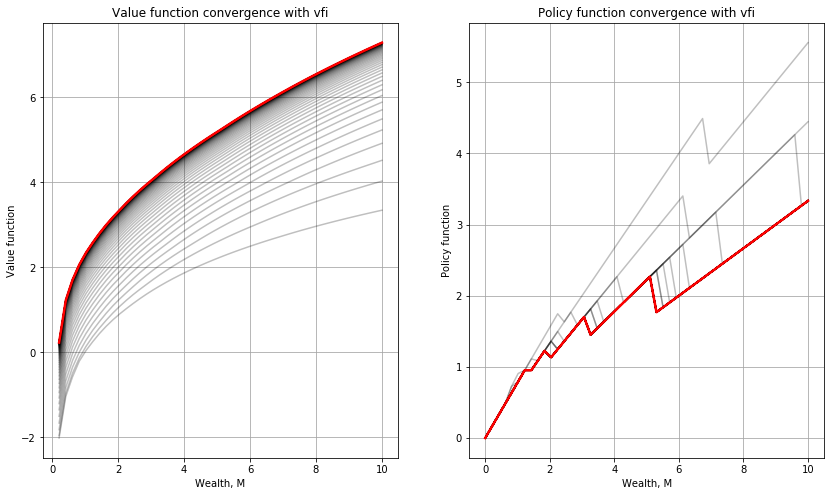

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

|||||||||||||||||||||||||||||||||||

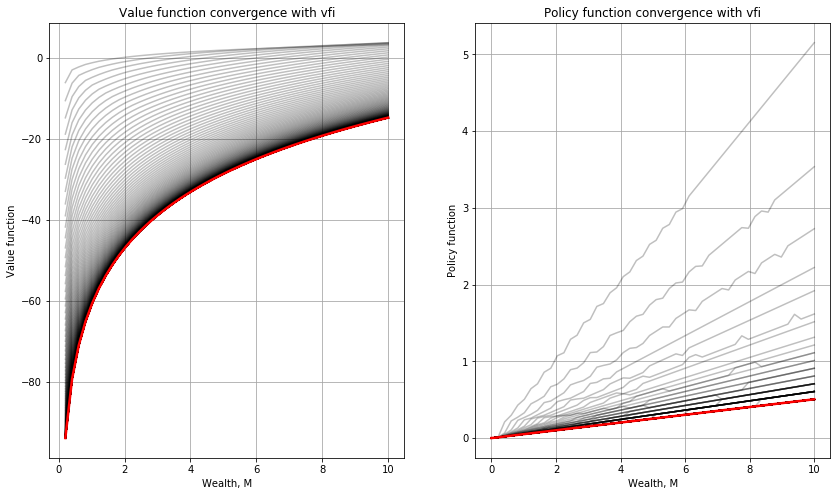

In [6]:
m = deaton(ngrid=50,nchgrid=10)
m.solve_vfi()
m.solve_plot(solver='vfi')

m = deaton(sigma=1e-8,R=1.05,beta=.95,nquad=1)
c,gr = m.solve_plot(solver='vfi')

<function matplotlib.pyplot.show(*args, **kw)>

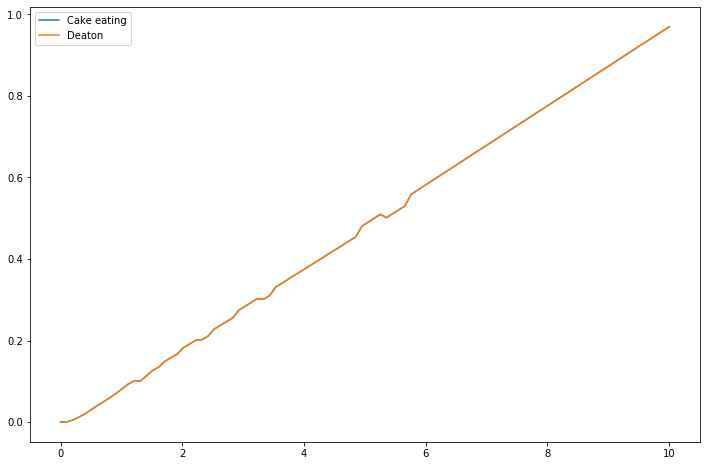

In [7]:
# Compare to the cake eating solution

m1 = cake_discretized(beta=0.9,Wbar=10,ngrid=100,nchgrid=300)
m2 = deaton(beta=0.9,Mbar=10,ngrid=100,nchgrid=300,R=1,nquad=1) # special case with nquad=1
v1,c1 = m1.solve()
v2,c2 = m2.solve_vfi()

plt.plot(m1.grid,c1,label='Cake eating')
plt.plot(m2.grid,c2,label='Deaton')
plt.legend()
plt.show

#### Further learning resources

- Cake eating problem on QuantEcon [https://python.quantecon.org/cake_eating_problem.html](https://python.quantecon.org/cake_eating_problem.html)  
- Stochastic growth problem on QuantEcon [https://python.quantecon.org/optgrowth.html](https://python.quantecon.org/optgrowth.html)  
- Income fluctuation problem on QuantEcon [https://python.quantecon.org/ifp.html](https://python.quantecon.org/ifp.html)  